In [1]:
import OpenEXR
from pprint import pprint
import os
from os import path
import pandas as pd
import seaborn as sns

print("EXR Python Lib loaded from:", OpenEXR.__file__)
print("Current working directory:", os.getcwd())

EXR Python Lib loaded from: /usr/lib/python3.10/OpenEXR.so
Current working directory: /mnt/c/Jupyter/testimages


In [2]:
# EXR test files we'll use in this benchmark example
input_filenames = ["ACES.StillLife.exr", 
                   "HDRSurvey_GoldenGate.exr",
                   "OpenEXR.Desk.exr"]

# Testing compression methods that we will use (including NO_COMPRESSION)
compression_methods = [(OpenEXR.NO_COMPRESSION, "RAW"),
                       (OpenEXR.RLE_COMPRESSION, "RLE"),
                       (OpenEXR.ZIPS_COMPRESSION, "ZIPS"),
                       (OpenEXR.ZIP_COMPRESSION, "ZIP"),
                       (OpenEXR.PIZ_COMPRESSION, "PIZ"),
                       (OpenEXR.PXR24_COMPRESSION, "PXR24"),
                       (OpenEXR.B44_COMPRESSION, "B44"),
                       (OpenEXR.B44A_COMPRESSION, "B44A"),
                       (OpenEXR.DWAA_COMPRESSION, "DWAA"),
                       (OpenEXR.DWAB_COMPRESSION, "DWAB")]

In [3]:
# Routine for write out an exr file with a given compression type
def reCompressThenLoad(exrFile, fileName, compressionType):
    header = exrFile.header()
    header["compression"] = compressionType
    exrFile.write(fileName)
    return path.getsize(fileName)    

## Iterate through the given test exr files, and record following data:
1. Raw bytestream size according to header data
2. File size using different compression method, including NO_Compression



In [4]:
records = []

for fn in input_filenames:
    desc = {}    
    assert(fn.endswith(".exr"))
    infile = OpenEXR.File(fn)
    desc["filename"] = fn
    header = infile.header()
    original_compression = header["compression"]
    original_filesize = path.getsize(fn)
    desc[original_compression.name] = original_filesize
    
    for method, shortname in compression_methods:
        if method != original_compression:
            new_fn = fn[:-4]+".{}.exr".format(shortname)
            filesize = reCompressThenLoad(infile, new_fn, method)
            desc[method.name] = filesize
    records.append(desc)

In [5]:
# Arrange by file name in a data frame for the compression ratios
df_data = []
header_row = ["Compression"]
for r in records:
    header_row.append(r["filename"])

for method, shortname in compression_methods:
    if method != OpenEXR.NO_COMPRESSION:
        df_row = [shortname]
        for r in records:
            raw_size = float(r[OpenEXR.NO_COMPRESSION.name])
            df_row.append(float(r[method.name])/raw_size)
        df_data.append(df_row)
            
df = pd.DataFrame(df_data)
df.columns = header_row

print(df)    

  Compression  ACES.StillLife.exr  HDRSurvey_GoldenGate.exr  OpenEXR.Desk.exr
0         RLE            0.702918                  0.714661          0.691201
1        ZIPS            0.544922                  0.540357          0.569665
2         ZIP            0.525979                  0.527138          0.511096
3         PIZ            0.536838                  0.487069          0.536730
4       PXR24            0.564085                  0.594444          0.547284
5         B44            0.437095                  0.437404          0.437290
6        B44A            0.351242                  0.437403          0.351430
7        DWAA            0.236935                  0.159923          0.245411
8        DWAB            0.231460                  0.157437          0.230691


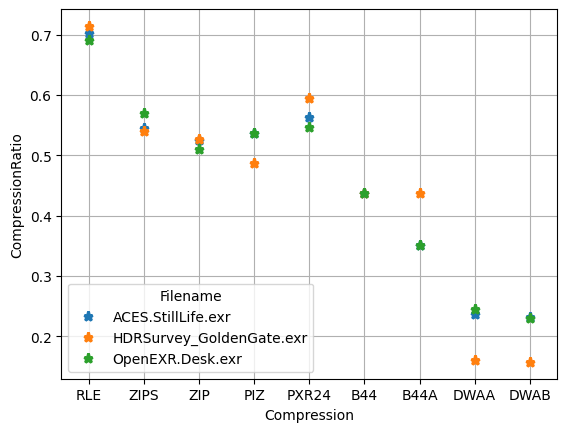

In [6]:
# Plot with Seaborn
dfm = df.melt(id_vars="Compression")
dfm.rename(columns={"variable": "Filename", "value": "CompressionRatio"}, inplace=True)
columns_to_plot = input_filenames

plt = sns.pointplot(data=dfm, x="Compression", y="CompressionRatio", hue="Filename", linestyle="none", markers="*")
plt.grid()